In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, default_collate, Dataset
from torchvision import transforms
from tqdm import tqdm
import pandas as pd
from PIL import Image
import torchvision
import os
from torchvision.transforms import v2
import glob
import torch.nn.functional as F
from torchvision.models import ResNet50_Weights
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import glob
import torch
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm
import seaborn as sns
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix
)
import torchvision.models as models
from copy import deepcopy

## Plotter

In [2]:
class Plotter:

    def plot_training_val_b1(self, training_loss, val_loss, val_accuracy):
        epochs = range(1, len(training_loss) + 1)

        fig, ax1 = plt.subplots()
        ax1.plot(epochs, training_loss, 'b-', label='Training Loss')
        ax1.plot(epochs, val_loss, 'r-', label='Validation Loss')
        ax1.set_xlabel('Epochs')
        ax1.set_ylabel('Loss')
        ax1.legend()
        ax1.set_title('Training and Validation Loss')

        plt.figure()
        plt.plot(epochs, val_accuracy, 'g-', label='Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.title('Validation Accuracy')

        plt.show()

    def plot_test_b1(self, loss, metrics, confusion_data):
        # Print metrics
        print(f"Loss: {loss:.4f}")
        print(f"Accuracy: {metrics['accuracy']:.4f}")
        print(f"Precision: {metrics['precision']:.4f}")
        print(f"Recall: {metrics['recall']:.4f}")
        print(f"F1 Score: {metrics['f1']:.4f}")

        # Plot confusion matrix
        cm = confusion_matrix(confusion_data['true_labels'], confusion_data['predictions'])
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix')
        plt.show()

plotter = Plotter()

## Data Processing

In [3]:
# class DataProcessorBaselineOne():
#     def __init__(self, videos_root, map_classes=True):
#         self.root = videos_root
#         self.data_classes = self.concat_annotations()
#         self.dataset = self.collect_video_data()

#         self.map_classes = map_classes
#         self.label_mapping = {'l-spike': 0, 'l_set': 1, 'r_set': 2, 'r-pass': 3, 'r_spike': 4, 'l-pass': 5, 'r_winpoint': 6, 'l_winpoint': 7}

#         self.dataset_df = self.__prepare_df()


#     def __prepare_df(self):
#         df = pd.DataFrame(self.dataset)
#         if self.map_classes:
#             df['mapped_class'] = df['class'].map(self.label_mapping)
#         return df

#     def get_dataset(self):
#         return self.dataset

#     def get_dataset_df(self):
#         return self.dataset_df

#     def __process_annotations(self, annotations_file):
#         data_dict = {}

#         with open(annotations_file, 'r') as file:
#             for line in file:
#                 parts = line.strip().split()

#                 if len(parts) > 1:  # Ensure there are at least 2 words
#                     filename = parts[0]  # First word is the filename
#                     action = parts[1]  # Second word is the action
#                     data_dict[filename] = action

#         return data_dict

#     def concat_annotations(self):
#         data_classes = {}
#         for video_folder in sorted(os.listdir(self.root)):  # Iterate over videos
#             video_path = os.path.join(self.root, video_folder)

#             if not os.path.isdir(video_path):
#                 continue  # Skip files, process only directories

#             for annotation_folder in sorted(os.listdir(video_path)):  # Iterate over clips
#                 annotation_path = os.path.join(video_path, annotation_folder)
#                 if not os.path.isdir(annotation_path):
#                     if annotation_folder == 'annotations.txt':
#                         data_classes = {**self.__process_annotations(annotation_path), **data_classes}

#         return data_classes

#     def collect_video_data(self):
#         dataset = []  # List to store video data
#         missing = 0
#         for video_folder in sorted(os.listdir(self.root)):  # Iterate over videos
#             video_path = os.path.join(self.root, video_folder)
#             if not os.path.isdir(video_path):
#                 continue  # Skip files, process only directories

#             for clip_folder in sorted(os.listdir(video_path)):  # Iterate over clips
#                 clip_path = os.path.join(video_path, clip_folder)
#                 if not os.path.isdir(clip_path):
#                     continue

#                 frames = sorted(
#                     [os.path.join(clip_path, f) for f in os.listdir(clip_path) if f.endswith(".jpg")]
#                 )
#                 if len(frames) == 41:  # Ensure expected number of frames
#                     target_frame = frames[20]
#                     frame_name = target_frame.split('/')[-1]
#                     if frame_name in self.data_classes:
#                         class_name = self.data_classes[frame_name]
#                         dataset.append({
#                             "video": video_folder,
#                             "clip": clip_folder,
#                             "frame": target_frame,
#                             "class": class_name
#                         })
#                     else:
#                         missing += 1

#         print(f'missing {missing} frames')
#         return dataset

Make sure you want to run this before running it

In [4]:
!rm -rf '/kaggle/working/'

rm: cannot remove '/kaggle/working/': Device or resource busy


In [5]:
# base_path = '/kaggle/input/volleyball/volleyball_/videos/'
# df = DataProcessorBaselineOne(base_path).get_dataset_df()

## Model

In [6]:
class FinetunableResnet(nn.Module):
    def __init__(self):
        super(FinetunableResnet, self).__init__()
        self.model = self.__get_model()

    def __get_model(self):
        resnet = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        num_features = resnet.fc.in_features
        layers = nn.Sequential(
            nn.Linear(num_features, 8)
        )
        resnet.fc = layers

        return resnet

    def get_fc(self):
        return self.model.fc

    def forward(self, images):
        return self.model(images)

## Training Utils

In [7]:
class TrainingUtilities:
    @staticmethod
    def save_model(model, model_descriptor, save_folder, verbose=0):
        torch.save(model.state_dict(), save_folder + f"/{model_descriptor}b1_model.pth")
        if verbose > 0:
            print(f"Saved model to {save_folder}/b1_model.pth")

    @staticmethod
    def save_checkpoint(epoch, model_state_dict, optimizer_state_dict, scheduler_state_dict=None, save_folder='', verbose=0):
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model_state_dict,
            'optimizer_state_dict': optimizer_state_dict,
            'scheduler_state_dict': scheduler_state_dict
        }
        torch.save(checkpoint, save_folder + f'/checkpoint-epoch{epoch}.pth')
        if verbose > 0:
            print(f'Saved checkpoint to {save_folder}/checkpoint-epoch{epoch}.pth')

    @staticmethod
    def load_checkpoint(model, optimizer, checkpoint_path, scheduled, verbose=0):
        checkpoint = torch.load(checkpoint_path)

        if verbose > 0:
            print(f"Loading checkpoint from {checkpoint_path}")

        epoch = checkpoint['epoch']
        model_state_dict = checkpoint['model_state_dict']
        optimizer_state_dict = checkpoint['optimizer_state_dict']
        scheduler_state_dict = checkpoint['scheduler_state_dict']
        model = model.load_state_dict(model_state_dict)
        if scheduled:
            optimizer.load_state_dict(optimizer_state_dict, scheduler_state_dict)
        else:
            optimizer = optimizer.load_state_dict(optimizer_state_dict)
        return epoch, model, optimizer

## Trainer

In [8]:
class b1_ModelTrainer:
    def __init__(self, model, optimizer, scheduled, criterion, epochs, dataloaders, device, save_folder,
                 is_continue=False, checkpoint=None):
        self.model = model
        self.optimizer = optimizer
        self.scheduled = scheduled
        self.criterion = criterion
        self.epochs = epochs
        self.dataloaders = dataloaders
        self.DEVICE = device
        self.save_folder = save_folder
        self.is_continue = is_continue
        self.checkpoint = checkpoint
        self.scaler = torch.amp.GradScaler()

    # verbose 1 : checkpoint,
    # verbose 3:  labels, preds
    # verbose 4: logits
    def train_model(self, verbose=0):
        model, optimizer, criterion, epochs, dataloaders, scaler = self.model, self.optimizer, self.criterion, self.epochs, self.dataloaders, self.scaler
        best_model = model
        best_acc = 0.0
        epoch = 0

        train_losses = []
        val_losses = []
        val_accuracies = []

        if self.is_continue:

            if verbose > 0:
                print(f"Continuing from checkpoint {self.checkpoint}")

            epoch, model, optimizer = self.__load_checkpoint(model, optimizer, self.checkpoint, verbose)

        for training_epoch in range(epoch, epochs):

            print(f"\nTraining epoch {training_epoch+1}")

            ## change model mode depending on the phase
            for phase in ['train', 'val']:
                dataloader = dataloaders[phase]
                epoch_loss = 0  # Track total loss for the epoch
                if phase == 'train':
                    if verbose > 0:
                        dataloader = tqdm(dataloader, desc=phase)
                    model.train()
                    for inputs, labels in dataloader:

                        inputs = inputs.to(self.DEVICE)
                        labels = labels.to(self.DEVICE)

                        if verbose > 3:
                            print(f"labels: {labels}")

                        # zero grads of he optim
                        optimizer.zero_grad()

                        # freeze the non-learnable weights
                        # self.__handle_transfer_learning(phase, training_epoch / epochs)

                        with torch.amp.autocast('cuda'):
                            # forward pass
                            logit = model(inputs)

                            if verbose > 3:
                                print(f"logit: {logit}")

                            loss = criterion(logit, labels)

                        scaler.scale(loss).backward()
                        optimizer.step(scaler)
                        scaler.update()

                        epoch_loss += loss.item()  # Accumulate loss

                    train_losses.append(epoch_loss / len(dataloader))
                    print(
                        f"Epoch {training_epoch + 1}/{epochs}, {phase} Loss: {epoch_loss / len(dataloader)}")  # Print loss
                else:
                    # skip evaluation if no suitable dataloader
                    if dataloaders[phase] is None:
                        continue
                    model.eval()
                    loss, acc = self.__eval_model(dataloader, verbose)
                    if acc > best_acc:
                        best_acc = acc
                        best_model = deepcopy(model)
                    val_losses.append(loss)
                    val_accuracies.append(acc)
                    print(
                        f"Epoch {training_epoch + 1}/{epochs}, ({phase}) Loss: {loss} | Accuracy: {acc}")  # Print loss

            if self.scheduled:
                optimizer.scheduler_step()
                if training_epoch % 10 == 0:
                    TrainingUtilities.save_checkpoint(training_epoch, model.state_dict(), optimizer.optimizer_state_dict(),
                                           optimizer.scheduler_state_dict(), self.save_folder, verbose)
            else:
                if training_epoch % 10 == 0:
                    TrainingUtilities.save_checkpoint(training_epoch, model.state_dict(), optimizer.state_dict(),self.save_folder, verbose)

            if training_epoch % 10 == 0:
                TrainingUtilities.save_model(model, training_epoch, self.save_folder,verbose)

        TrainingUtilities.save_model(best_model, 'final_', self.save_folder, verbose)
        return train_losses, val_losses, val_accuracies, best_model

    def __handle_transfer_learning(self, phase, ratio_epochs, tl_coeff=0, verbose=0):
        if phase == "train":
            if self.__check_transfer_learning(ratio_epochs, tl_coeff):
                # Unfreeze all layers for fine-tuning
                for param in self.model.parameters():
                    param.requires_grad = True
            else:
                # Freeze the CNN part
                for param in self.model.parameters():
                    param.requires_grad = False
                # Unfreeze the classification layer
                for param in self.model.get_fc().parameters():
                    param.requires_grad = True
        elif phase == "val":
            for param in self.model.parameters():
                param.requires_grad = False

    def __check_transfer_learning(self, ratio_epochs, tl_coeff=0):
        return ratio_epochs >= tl_coeff

    def __eval_model(self, dataloader, verbose=0):
        model = self.model
        criterion = self.criterion
        model.eval()
        val_loss = 0
        correct_preds = 0
        total_preds = 0
        if verbose > 0:
            dataloader = tqdm(dataloader, desc="Validation")
        with torch.no_grad():
            with torch.amp.autocast('cuda'):
                for inputs, labels in dataloader:
                    inputs = inputs.to(self.DEVICE)
                    labels = labels.to(self.DEVICE)

                    if verbose > 2:
                        print(f"labels: {labels}")

                    # Forward pass
                    logits = model(inputs)

                    if verbose > 3:
                        print(f"logit: {logits}")

                    probs = F.softmax(logits, dim=1)  # Apply softmax to get probabilities

                    if verbose > 3:
                        print(f"probs: {probs}")

                    loss = criterion(logits, labels)
                    val_loss += loss.item()  # Accumulate loss

                    # Compute accuracy
                    predicted = torch.argmax(probs, dim=1)  # Get the class with the highest probability

                    if verbose > 2:
                        print(f"predicted: {predicted}")
                        print(f"true/false: {(predicted == labels)}")

                    correct_preds += (predicted == labels).sum().item()
                    total_preds += labels.size(0)

        # Calculate average loss and accuracy
        avg_loss = val_loss / len(dataloader)
        accuracy = correct_preds / total_preds
        return avg_loss, accuracy

## Dataset

In [9]:
# class B1Dataset(Dataset):

#     VIDEO_SPLITS = {
#         'train': {1, 3, 6, 7, 10, 13, 15, 16, 18, 22, 23, 31, 32, 36, 38, 39, 40, 41, 42, 48, 50, 52, 53, 54},
#         'val': {0, 2, 8, 12, 17, 19, 24, 26, 27, 28, 30, 33, 46, 49, 51},
#         'test': {4, 5, 9, 11, 14, 20, 21, 25, 29, 34, 35, 37, 43, 44, 45, 47}
#     }

#     def __init__(self, data, split='train', transform=None):
#         self.data = data
#         if transform is None:
#             self.transform = transforms.Compose([
#                 transforms.Resize((256, 256)),
#                 transforms.CenterCrop((224, 224)),
#                 transforms.ToTensor(),
#                 transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
#             ])
#         else:
#             self.transform = transform

#         if split in self.VIDEO_SPLITS:
#             self.data = self.data[self.data['video'].astype(int).isin(self.VIDEO_SPLITS[split])].reset_index(drop=True)
#         else:
#             raise NameError(f'There is no such split: {split}, only {self.VIDEO_SPLITS}')

#     def get_labels(self):
#         return self.data['mapped_class'].tolist()

#     def __len__(self):
#         return len(self.data)

#     def __getitem__(self, idx):
#         img_path = self.data.iloc[idx]['frame']
#         label = self.data.iloc[idx]['mapped_class']

#         # Load image
#         image = Image.open(img_path).convert("RGB")

#         # Apply transformations if provided
#         image = self.transform(image)
#         return image, torch.tensor(label, dtype=torch.long)

## Loss

In [10]:
class WeightedCrossEntropyLoss(nn.Module):
    def __init__(self, dataset, device, num_classes=8):
        super().__init__()
        self.device = device
        self.num_classes = num_classes
        self.weights = self.__compute_weights(dataset).to(device)
        self.loss = nn.CrossEntropyLoss(weight=self.weights)

    def __compute_weights(self, dataset):
        labels = torch.tensor(dataset.get_labels(), dtype=torch.long)
        class_counts = torch.bincount(labels, minlength=self.num_classes)
        total_samples = len(labels)
        weights = total_samples / (class_counts + 1e-6)  # Avoid div by zero
        return weights.float()

    def forward(self, logit, target):
        return self.loss(logit, target)

In [11]:
class AugmentationCELoss(WeightedCrossEntropyLoss):
    def __init__(self, dataset, device, num_classes):
        super().__init__(dataset, device, num_classes)

    def forward(self, logit, target):
        return F.cross_entropy(logit, target, weight=self.weights)

## Optimizer

In [12]:
class AdamWScheduled():
    def __init__(self, model_params, lr, step_size, gamma, weight_decay):
        self.optimizer = optim.AdamW(model_params,  lr=lr, weight_decay=weight_decay)
        self.scheduler = optim.lr_scheduler.StepLR(self.optimizer, step_size, gamma)

    def step(self, scaler):
        scaler.step(self.optimizer)

    def zero_grad(self):
        self.optimizer.zero_grad()

    def scheduler_step(self):
        self.scheduler.step()

    def optimizer_state_dict(self):
        return self.optimizer.state_dict()

    def scheduler_state_dict(self):
        return self.scheduler.state_dict()

    def load_state_dict(self, optimizer_state_dict, scheduler_state_dict):
        self.optimizer.load_state_dict(optimizer_state_dict)
        self.scheduler.load_state_dict(scheduler_state_dict)

## Custom Dataloader

In [13]:
class AugmentationDataLoader():
    def __init__(self, dataset, batch_size, shuffle, num_workers, pin_memory, num_classes, mixup_alpha=1.0, cutmix_alpha=1.0):
        mixup_alpha = float(mixup_alpha)
        cutmix_alpha = float(cutmix_alpha)

        cutmix = v2.CutMix(num_classes=num_classes, alpha=cutmix_alpha)
        mixup = v2.MixUp(num_classes=num_classes, alpha=mixup_alpha)
        self.cutmix_or_mixup = v2.RandomChoice([cutmix, mixup])
        self.loader = DataLoader(dataset, batch_size=batch_size, num_workers=num_workers, pin_memory=pin_memory, shuffle=shuffle, collate_fn=self.collate_fn)

    def get_loader(self):
        return self.loader

    def collate_fn(self, batch):
        inputs, labels = default_collate(batch)
        return self.cutmix_or_mixup(inputs, labels)

## Dataloaders and Transforms

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [15]:
# train_dataset = B1Dataset(df, split='train')
# val_dataset = B1Dataset(df, split='val')
# test_dataset = B1Dataset(df, split='test')

In [16]:
def extract_target_image_and_label(video_id, dataset_path):
    """
    Extracts all target image paths and corresponding frame activity class from the annotations.txt file.
    """
    video_path = os.path.join(dataset_path, str(video_id))  # Video directory path
    annotation_file = os.path.join(video_path, 'annotations.txt')  # Path to annotation file
    
    # List to store (image_path, activity_class)
    images_and_labels = []
    
    # Read annotations.txt
    with open(annotation_file, 'r') as f:
        for line in f:
            parts = line.strip().split()
            # Extract the frame ID (image name) and frame activity class
            frame_image = parts[0]  # Image name (e.g., '48075.jpg')
            frame_activity_class = parts[1]  # Frame Activity Class (e.g., 'r_winpoint')
            
            # Remove .jpg from frame_image to get the frame ID
            frame_id = os.path.splitext(frame_image)[0]
            
            # Construct the expected path to the target image
            target_image_path = os.path.join(video_path, str(frame_id), frame_image)
            
            # Check if the file exists
            if os.path.exists(target_image_path):
                images_and_labels.append((target_image_path, frame_activity_class))
            else:
                print(f"Target image not found: {target_image_path}")
    
    return images_and_labels


def prepare_dataset(video_ids, dataset_path):
    """
    Prepares the dataset by extracting the target image paths and their labels for the given video IDs.
    Returns a list of tuples (image_path, activity_class).
    """
    dataset = []
    
    for video_id in video_ids:
        # Extract target image paths and labels for this video
        images_and_labels = extract_target_image_and_label(video_id, dataset_path)
        dataset.extend(images_and_labels)  # Add them to the dataset list
    
    return dataset

# Video IDs for each dataset split
train_videos = [1, 3, 6, 7, 10, 13, 15, 16, 18, 22, 23, 31, 32, 36, 38, 39, 40, 41, 42, 48, 50, 52, 53, 54]
val_videos = [0, 2, 8, 12, 17, 19, 24, 26, 27, 28, 30, 33, 46, 49, 51]
test_videos = [4, 5, 9, 11, 14, 20, 21, 25, 29, 34, 35, 37, 43, 44, 45, 47]

# Dataset path 
dataset_path = '/kaggle/input/volleyball/volleyball_/videos'

# Prepare datasets for train, validation, and test splits
train_data = prepare_dataset(train_videos, dataset_path)
val_data = prepare_dataset(val_videos, dataset_path)
test_data = prepare_dataset(test_videos, dataset_path)


class VideoFrameDataset(Dataset):
    def __init__(self, data, transform=None):
        """
        Args:
            data: List of tuples (image_path, label)
            transform: Optional transformations to be applied on a sample
        """
        self.data = data
        self.transform = transform
        self.class_mapping = {'r_set': 0, 'r_spike': 1, 'r-pass': 2, 'r_winpoint': 3,
                              'l_winpoint': 4, 'l-pass': 5, 'l-spike': 6, 'l_set':7} 
    def get_labels(self):
        labels = []
        for image_path, label in self.data:
            labels.append(self.class_mapping[label])
        return labels
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Get image path and label
        image_path, label = self.data[idx]

        # Open the image
        image = Image.open(image_path).convert('RGB')

        # Apply transformations
        if self.transform:
            image = self.transform(image)

        # Convert label to a numeric tensor using the class mapping
        label = torch.tensor(self.class_mapping[label], dtype=torch.long)

        return image, label

train_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),                                   # Convert PIL images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406],        # Normalize using ImageNet mean and std values
                         std=[0.229, 0.224, 0.225]),         # (mean and std are the same used during ResNet pre-training)
])

train_dataset = VideoFrameDataset(train_data, transform=train_transform)
val_dataset = VideoFrameDataset(val_data, transform=train_transform)
test_dataset = VideoFrameDataset(test_data, transform=train_transform)

In [17]:
batch_size = 100
train_loader = AugmentationDataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True, num_classes=8, mixup_alpha=0.9, cutmix_alpha=0.9).get_loader()
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
dataloaders = {'train': train_loader, 'val': val_loader}

## Custom Criterion

In [18]:
# criterion = WeightedCrossEntropyLoss(train_dataset, device)
criterion = AugmentationCELoss(dataset=train_dataset, device=device, num_classes=8)

## Model Training

In [19]:
model = FinetunableResnet().to(device)
optimizer = AdamWScheduled(model_params=model.parameters(), lr=0.001, step_size=10, gamma=0.1, weight_decay=1)

save_folder = '/kaggle/working/'
trainer = b1_ModelTrainer(model, optimizer,True, criterion, epochs=30, dataloaders=dataloaders, device=device, save_folder=save_folder)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 191MB/s]


In [20]:
train_losses, val_losses, val_accuracies, best_model = trainer.train_model(verbose=0)


Training epoch 1
Epoch 1/30, train Loss: 15.985152938149191
Epoch 1/30, (val) Loss: 2.9246708154678345 | Accuracy: 0.1931394481730052

Training epoch 2
Epoch 2/30, train Loss: 12.252706397663463
Epoch 2/30, (val) Loss: 1.4509595206805639 | Accuracy: 0.465324384787472

Training epoch 3
Epoch 3/30, train Loss: 11.339457620273937
Epoch 3/30, (val) Loss: 1.0940611021859306 | Accuracy: 0.5958240119313944

Training epoch 4
Epoch 4/30, train Loss: 9.332895907488735
Epoch 4/30, (val) Loss: 1.8168505941118513 | Accuracy: 0.37285607755406414

Training epoch 5
Epoch 5/30, train Loss: 10.110160025683316
Epoch 5/30, (val) Loss: 1.4848697440964835 | Accuracy: 0.39746457867263235

Training epoch 6
Epoch 6/30, train Loss: 9.451185118068349
Epoch 6/30, (val) Loss: 1.0740875729492732 | Accuracy: 0.575689783743475

Training epoch 7
Epoch 7/30, train Loss: 8.340808684175665
Epoch 7/30, (val) Loss: 1.0548412459237235 | Accuracy: 0.6360924683072334

Training epoch 8
Epoch 8/30, train Loss: 8.41938413273204

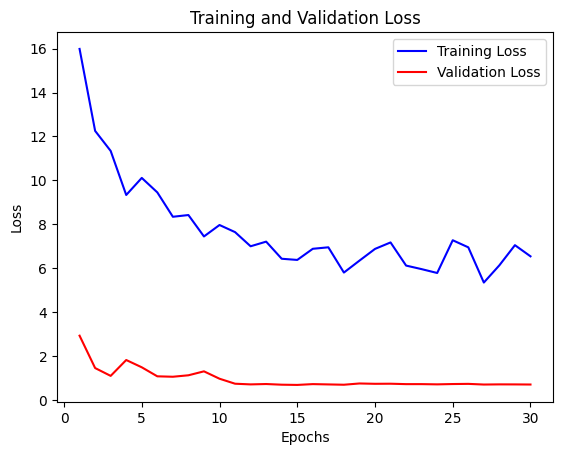

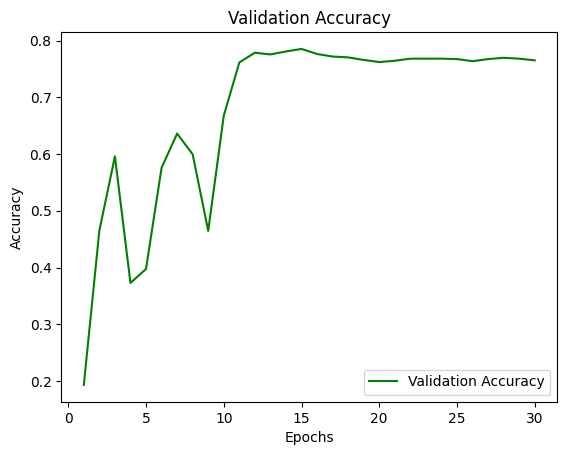

In [21]:
plotter.plot_training_val_b1(train_losses, val_losses, val_accuracies)

## Model Evaluation

In [22]:
class b1_ModelTester():
    def __init__(self, model, model_path, criterion, dataloader, device):
        self.model = model
        # model_state_dict = torch.load(model_path, map_location=device)
        # self.model.load_state_dict(model_state_dict)
        self.criterion = criterion
        self.dataloader = dataloader
        self.DEVICE = device

    def evaluate(self, verbose=0):
        dataloader = self.dataloader
        model = self.model
        criterion = self.criterion
        model.eval()

        # Initialize metrics tracking
        val_loss = 0
        all_labels = []
        all_predictions = []
        all_probabilities = []

        if verbose > 0:
            dataloader = tqdm(dataloader, desc="Testing")

        with torch.no_grad():
            with torch.amp.autocast('cuda'):
                for inputs, labels in dataloader:
                    inputs = inputs.to(self.DEVICE, non_blocking=True)
                    labels = labels.to(self.DEVICE, non_blocking=True)

                    if verbose > 2:
                        print(f"labels: {labels}")

                    # Forward pass
                    logits = model(inputs)
                    probs = F.softmax(logits, dim=1)

                    if verbose > 3:
                        print(f"logits: {logits}")
                        print(f"probs: {probs}")

                    # Calculate loss
                    loss = criterion(logits, labels)
                    val_loss += loss.item()

                    # Get predictions
                    predicted = torch.argmax(probs, dim=1)

                    if verbose > 2:
                        print(f"predicted: {predicted}")
                        print(f"true/false: {(predicted == labels)}")

                    # Store predictions and labels for later metric calculation
                    all_labels.extend(labels.cpu().numpy())
                    all_predictions.extend(predicted.cpu().numpy())
                    all_probabilities.extend(probs.cpu().numpy())

        # Calculate average loss
        avg_loss = val_loss / len(dataloader)

        # Convert lists to numpy arrays for easier manipulation
        all_labels = np.array(all_labels)
        all_predictions = np.array(all_predictions)
        all_probabilities = np.array(all_probabilities)

        # Calculate metrics for each class
        num_classes = all_probabilities.shape[1]
        metrics_dict = {
            'accuracy': accuracy_score(all_labels, all_predictions),
            'precision': precision_score(all_labels, all_predictions, average='macro', zero_division=0),
            'recall': recall_score(all_labels, all_predictions, average='macro', zero_division=0),
            'f1': f1_score(all_labels, all_predictions, average='macro', zero_division=0),
            'per_class': {
                'precision': precision_score(all_labels, all_predictions, average=None, zero_division=0),
                'recall': recall_score(all_labels, all_predictions, average=None, zero_division=0),
                'f1': f1_score(all_labels, all_predictions, average=None, zero_division=0)
            }
        }

        # Prepare confusion matrix data
        confusion_data = {
            'true_labels': all_labels,
            'predictions': all_predictions,
            'probabilities': all_probabilities,
            'num_classes': num_classes
        }

        return avg_loss, metrics_dict, confusion_data

In [23]:
# model = FinetunableResnet101().to(device)
model_path = '/kaggle/working/final_b1_model.pth'
tester = b1_ModelTester(best_model, model_path, criterion, test_loader, device)

In [24]:
loss, metrics, confusion_data = tester.evaluate(verbose=1)

Testing: 100%|██████████| 14/14 [00:15<00:00,  1.09s/it]


Loss: 0.6701
Accuracy: 0.7996
Precision: 0.8115
Recall: 0.8180
F1 Score: 0.8142


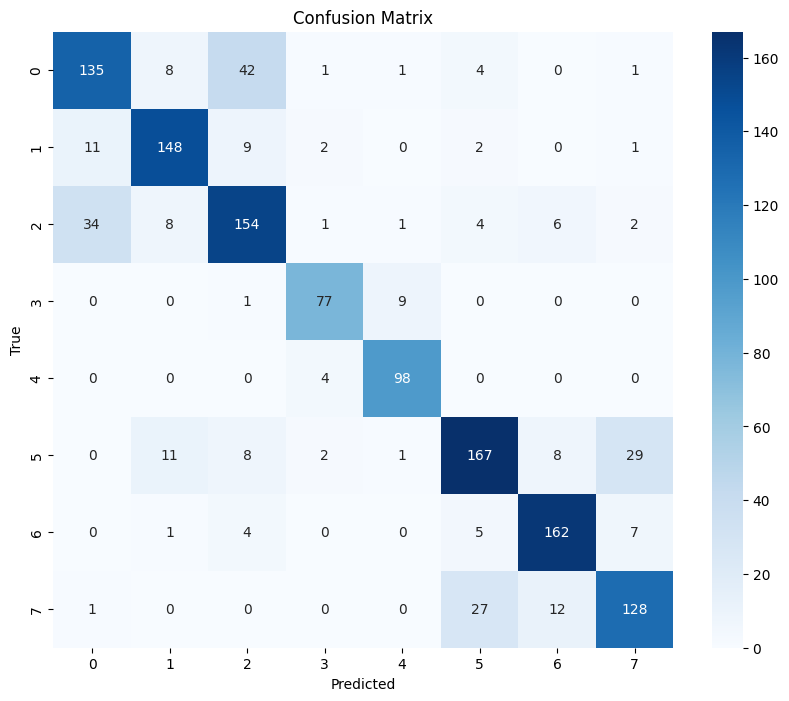

In [25]:
plotter.plot_test_b1(loss, metrics, confusion_data)